In [1]:
import numpy as np
import h5py
import networkx as nx
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab as pl

In [2]:
def make_matrix(filename):
    h5f = h5py.File(filename, 'r')
    data = h5f['data'][:]
    patient_list = h5f['patient-list'][:]
    h5f.close()
    return data, patient_list

## HNU-1 Dataset Results

In [3]:
X, patients = make_matrix('../../src/data/HNU1.h5')

from src.features.summary_17 import Stats

data_matrix = []
for i in X:
    adj = np.matrix(i)

    g = nx.from_numpy_matrix(adj)
    stats = Stats(g).return_stats()
    data_matrix.append(np.array(stats))

data_matrix = np.matrix(data_matrix)

c:\users\smile\anaconda3\envs\python36_env\lib\site-packages\networkx\drawing\nx_pylab.py:611: MatplotlibDeprecationWarning: isinstance(..., numbers.Number)
  if cb.is_numlike(alpha):


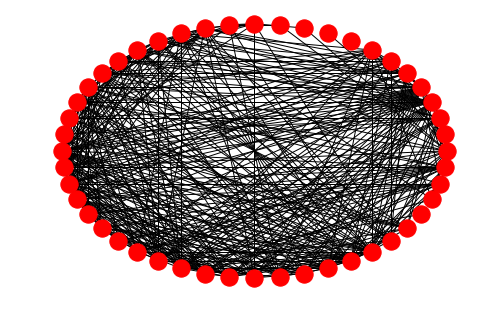

In [4]:
nx.draw_circular(g)

Prior to projection, results appears to indicate only 2 clusters with a high silhouette score. We know that we should be seeing 30 clusters in the HNU dataset.

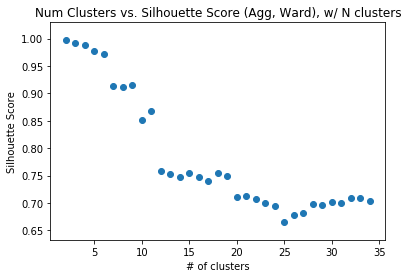

Best sillhouette score: [0.9977842346007438]
Best num clusters: [2]


In [5]:
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score
from sklearn.metrics import adjusted_rand_score
import math

best_ss = []
plt.figure()
plt.title('Num Clusters vs. Silhouette Score (Agg, Ward), w/ N clusters')
x = range(2,35)
silhouettes = []
for i in x:
    X = data_matrix
    clustering = AgglomerativeClustering(n_clusters=i).fit(X)
    silhouettes.append(silhouette_score(X, clustering.labels_, metric='sqeuclidean'))

plt.xlabel('# of clusters')
plt.ylabel('Silhouette Score')
plt.scatter(x, silhouettes)

best_ss.append(max(silhouettes))
plt.savefig('HNU_aggclust_sil_per_clust.png')
plt.show()

print('Best sillhouette score:', best_ss)
print('Best num clusters:', [x[i] for i in range(len(silhouettes)) if silhouettes[i]==max(silhouettes)])


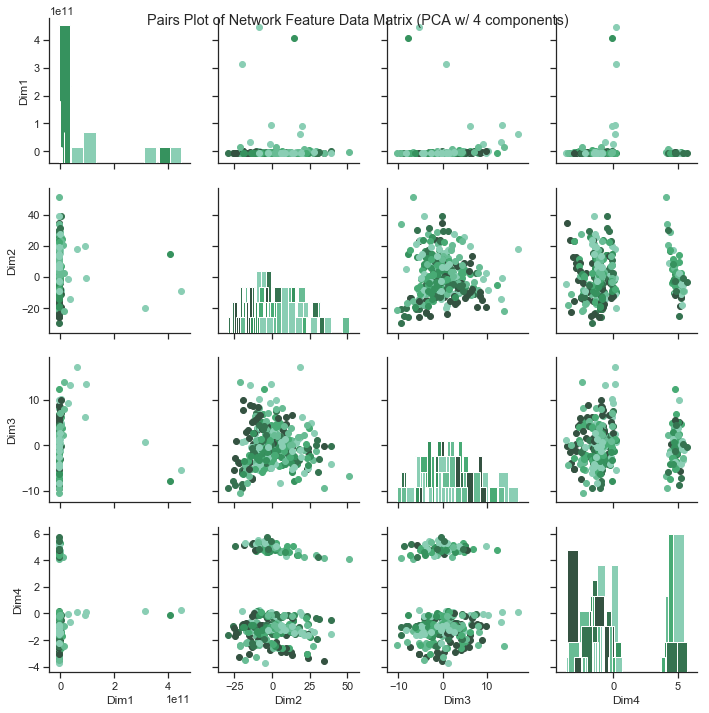

In [6]:
import seaborn as sns
import pandas as pd

# Project data
pca = PCA(n_components=4, svd_solver='full')
four_comp = pca.fit_transform(data_matrix)

temp = []
for i in patients:
    temp.append(i.decode('utf-8').split('_')[0])

d = {ni: indi for indi, ni in enumerate(set(temp))}
true_labels = [d[ni] for ni in temp]

data_ = {
    'Dim1': four_comp[:, 0],
    'Dim2': four_comp[:, 1],
    'Dim3': four_comp[:, 2],
    'Dim4': four_comp[:, 3],
    'labels': true_labels
}
temp = pd.DataFrame(data_)
sns.set(style="ticks", color_codes=True)

# Plot in pairs
temp['species'] = true_labels
img = sns.PairGrid(temp, hue='species', vars=['Dim1', 'Dim2', 'Dim3', 'Dim4'], palette=sns.color_palette("BuGn_d"))
img = img.map_diag(plt.hist)
img = img.map_offdiag(plt.scatter)
plt.suptitle('Pairs Plot of Network Feature Data Matrix (PCA w/ 4 components)')
img.savefig('HNU_4comp_pairsplot.png')

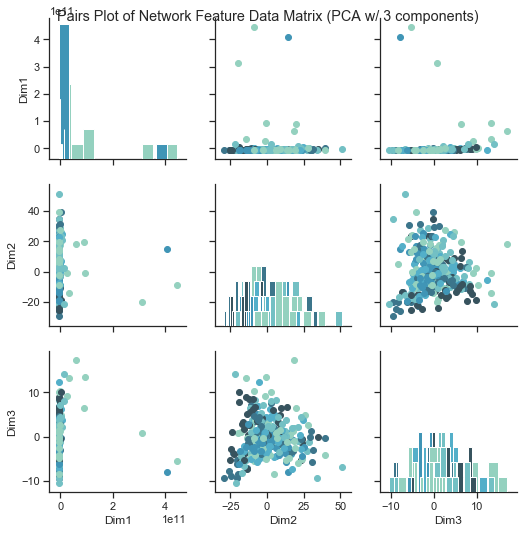

In [7]:
# Project data
pca = PCA(n_components=3, svd_solver='full')
three_comp = pca.fit_transform(data_matrix)

data_ = {
    'Dim1': three_comp[:, 0],
    'Dim2': three_comp[:, 1],
    'Dim3': three_comp[:, 2],
    'labels': true_labels
}
temp = pd.DataFrame(data_)
sns.set(style="ticks", color_codes=True)

# Plot in pairs
temp['species'] = true_labels
img = sns.PairGrid(temp, hue='species', vars=['Dim1', 'Dim2', 'Dim3'], palette=sns.color_palette("GnBu_d"))
img = img.map_diag(plt.hist)
img = img.map_offdiag(plt.scatter)
plt.suptitle('Pairs Plot of Network Feature Data Matrix (PCA w/ 3 components)')
img.savefig('HNU_3comp_pairsplot.png')

After PCA into 2D, 2 clusters can be seen very clearly while 30 has overlapping clusters.

0.7016062640976537


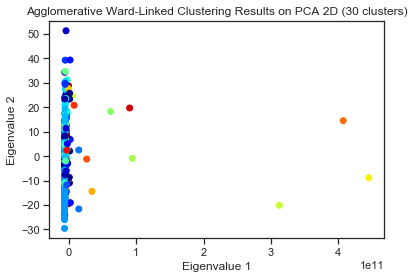

0.9977842346007438


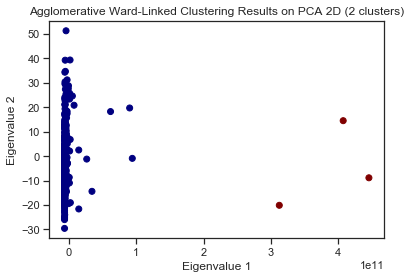

In [10]:
# 30 clusters
pca = PCA(n_components=2, svd_solver='full')
X = pca.fit_transform(data_matrix)
aggclust = AgglomerativeClustering(n_clusters=30).fit(X)
# print(clustering.labels_)
print(silhouette_score(X, aggclust.labels_, metric='sqeuclidean'))

plt.figure()
plt.title("Agglomerative Ward-Linked Clustering Results on PCA 2D (30 clusters)")
plt.xlabel("Eigenvalue 1")
plt.ylabel("Eigenvalue 2")
plt.scatter(X[:, 0], X[:, 1], c=aggclust.labels_,cmap=plt.cm.jet)
plt.savefig('HNU_aggclust_30clust_pca2d.png')
plt.show()

# 2 clusters
pca = PCA(n_components=2, svd_solver='full')
X = pca.fit_transform(data_matrix)
aggclust = AgglomerativeClustering(n_clusters=2).fit(X)
# print(clustering.labels_)
print(silhouette_score(X, aggclust.labels_, metric='sqeuclidean'))

plt.figure()
plt.title("Agglomerative Ward-Linked Clustering Results on PCA 2D (2 clusters)")
plt.xlabel("Eigenvalue 1")
plt.ylabel("Eigenvalue 2")
plt.scatter(X[:, 0], X[:, 1], c=aggclust.labels_,cmap=plt.cm.jet)
plt.savefig('HNU_aggclust_2clust_pca2d.png')
plt.show()

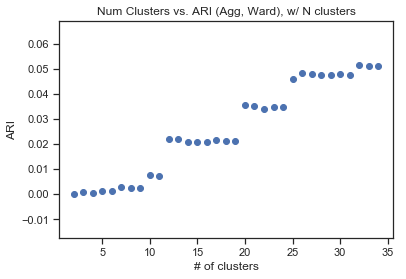

Best ARI: [0.051449939213754396]
Best num clusters: [32]


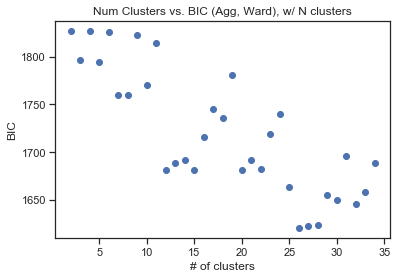

Best BIC: [1620.4247550418793]
Best num clusters: [26]


In [13]:
# Computing ARI score for N clusters, no PCA
from sklearn.metrics import adjusted_rand_score

best_ari = []
best_bic = []
x = range(2,35)
aris = []
bics = []
n = np.shape(data_matrix)[0]
k = np.shape(data_matrix)[1]
for i in x:
    clustering = AgglomerativeClustering(n_clusters=i).fit(data_matrix)
    aris.append(adjusted_rand_score(true_labels, clustering.labels_))
    resid = true_labels - clustering.labels_
    sse = sum(resid**2)
    bics.append(n * np.log(sse/n) + k*np.log(n))

# Plotting ARI
plt.figure()
plt.title('Num Clusters vs. ARI (Agg, Ward), w/ N clusters')
plt.xlabel('# of clusters')
plt.ylabel('ARI')
plt.scatter(x, aris)

best_ari.append(max(aris))
plt.savefig('HNU_aggclust_ari_per_clust.png')
plt.show()

# Results summary
print('Best ARI:', best_ari)
print('Best num clusters:', [x[i] for i in range(len(aris)) if aris[i]==max(aris)])

# Plotting BIC
plt.figure()
plt.title('Num Clusters vs. BIC (Agg, Ward), w/ N clusters')
plt.xlabel('# of clusters')
plt.ylabel('BIC')
plt.scatter(x, bics)

best_bic.append(min(bics))
plt.savefig('HNU_aggclust_bic_per_clust.png')
plt.show()

# Results summary
print('Best BIC:', best_bic)
print('Best num clusters:', [x[i] for i in range(len(bics)) if bics[i]==min(bics)])
